In [1]:
msg = "Hello World"
print(msg)

Hello World


In [2]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

import glob

raw_data_files = glob.glob('../ansible/.results-v2-2/bpftrace/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-------------------------------------------------------------+
|value                                                        |
+-------------------------------------------------------------+
|Attaching 12 probes...                                       |
|Tracing latency of network stack funtions. Hit Ctrl-C to end.|
|@q1[swapper/169]: count 203, average 2397, total 486772      |
|@q1[ksoftirqd/169]: count 8, average 4115, total 32922       |
|@q1[kworker/169:2]: count 2, average 7559, total 15118       |
|@q1[iperf]: count 1, average 11652, total 11652              |
|                                                             |
|@q2[kworker/169:2]: count 3, average 4568, total 13706       |
|@q2[swapper/169]: count 794, average 6017, total 4777892     |
|@q2[iperf]: count 1, average 8656, total 8656                |
+-------------------------------------------------------------+
only showing top 10 rows



In [3]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['Attaching 12 probes...',
 'Tracing latency of network stack funtions. Hit Ctrl-C to end.',
 '@q1[swapper/169]: count 203, average 2397, total 486772',
 '@q1[ksoftirqd/169]: count 8, average 4115, total 32922',
 '@q1[kworker/169:2]: count 2, average 7559, total 15118',
 '@q1[iperf]: count 1, average 11652, total 11652',
 '',
 '@q2[kworker/169:2]: count 3, average 4568, total 13706',
 '@q2[swapper/169]: count 794, average 6017, total 4777892',
 '@q2[iperf]: count 1, average 8656, total 8656',
 '@q2[ksoftirqd/169]: count 47, average 426632, total 20051729',
 '',
 '',
 '@q4[swapper/169]: count 9658, average 1619, total 15642297',
 '@q4[ksoftirqd/169]: count 318, average 2114, total 672297']

In [4]:
bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
ps = [re.search(bpftrace_ps_pattern, item).groups()
           if re.search(bpftrace_ps_pattern, item)
           else None
           for item in sample_logs]
ps

[None,
 None,
 ('q1', 'swapper/169', '203', '2397', '486772', ''),
 ('q1', 'ksoftirqd/169', '8', '4115', '32922', ''),
 ('q1', 'kworker/169:2', '2', '7559', '15118', ''),
 ('q1', 'iperf', '1', '11652', '11652', ''),
 None,
 ('q2', 'kworker/169:2', '3', '4568', '13706', ''),
 ('q2', 'swapper/169', '794', '6017', '4777892', ''),
 ('q2', 'iperf', '1', '8656', '8656', ''),
 ('q2', 'ksoftirqd/169', '47', '426632', '20051729', ''),
 None,
 None,
 ('q4', 'swapper/169', '9658', '1619', '15642297', ''),
 ('q4', 'ksoftirqd/169', '318', '2114', '672297', '')]

In [5]:
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
cs = [re.search(bpftrace_cs_pattern, item).groups()
           if re.search(bpftrace_cs_pattern, item)
           else None
           for item in sample_logs]
cs

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+---------+
|cs_count|cs_average| cs_total|
+--------+----------+---------+
|    9139|     13868|126744395|
|   13685|      2723| 37274173|
|   13957|      3021| 42167448|
|   13761|      2683| 36923098|
|   13883|      2801| 38897950|
|   13682|      2594| 35499792|
|   14045|      2722| 38232932|
|   13886|      2758| 38310160|
|   13326|      2820| 37586502|
|   13733|      2647| 36360710|
|   14324|      4025| 57668375|
|   13811|      2974| 41076257|
|   13535|      2605| 35271242|
|   13881|      2502| 34733746|
|   13722|      3102| 42568507|
+--------+----------+---------+
only showing top 15 rows



In [7]:
print(bpftrace_cs_df.toPandas().to_numpy()[0])

['9139' '13868' '126744395']


In [8]:
from pyspark.sql.functions import regexp_extract

bpftrace_logs_df = base_df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
bpftrace_logs_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+
|level|      program|pkt_count|pkt_average|pkt_total|
+-----+-------------+---------+-----------+---------+
|   q1|  swapper/169|      203|       2397|   486772|
|   q1|ksoftirqd/169|        8|       4115|    32922|
|   q1|kworker/169:2|        2|       7559|    15118|
|   q1|        iperf|        1|      11652|    11652|
|   q2|kworker/169:2|        3|       4568|    13706|
|   q2|  swapper/169|      794|       6017|  4777892|
|   q2|        iperf|        1|       8656|     8656|
|   q2|ksoftirqd/169|       47|     426632| 20051729|
|   q4|  swapper/169|     9658|       1619| 15642297|
|   q4|ksoftirqd/169|      318|       2114|   672297|
|   q4|kworker/169:2|        5|       3486|    17433|
|   q4|        iperf|        1|      12414|    12414|
|   q5|  swapper/169|    72860|        722| 52653083|
|   q5|ksoftirqd/169|     2309|        804|  1856931|
|   q5|kworker/169:2|       27|       1043|    28169|
+-----+-------------+-------

In [9]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+---------+
|cs_count|cs_average| cs_total|
+--------+----------+---------+
|    9139|     13868|126744395|
|   13685|      2723| 37274173|
|   13957|      3021| 42167448|
|   13761|      2683| 36923098|
|   13883|      2801| 38897950|
|   13682|      2594| 35499792|
|   14045|      2722| 38232932|
|   13886|      2758| 38310160|
|   13326|      2820| 37586502|
|   13733|      2647| 36360710|
|   14324|      4025| 57668375|
|   13811|      2974| 41076257|
|   13535|      2605| 35271242|
|   13881|      2502| 34733746|
|   13722|      3102| 42568507|
+--------+----------+---------+
only showing top 15 rows



In [10]:
cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]
print(cs_array)

['9139' '13868' '126744395']


In [11]:
from pyspark.sql.functions import lit

bpftrace_res_df = bpftrace_logs_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
bpftrace_res_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+---------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average| cs_total|
+-----+-------------+---------+-----------+---------+--------+----------+---------+
|   q1|  swapper/169|      203|       2397|   486772|    9139|     13868|126744395|
|   q1|ksoftirqd/169|        8|       4115|    32922|    9139|     13868|126744395|
|   q1|kworker/169:2|        2|       7559|    15118|    9139|     13868|126744395|
|   q1|        iperf|        1|      11652|    11652|    9139|     13868|126744395|
|   q2|kworker/169:2|        3|       4568|    13706|    9139|     13868|126744395|
|   q2|  swapper/169|      794|       6017|  4777892|    9139|     13868|126744395|
|   q2|        iperf|        1|       8656|     8656|    9139|     13868|126744395|
|   q2|ksoftirqd/169|       47|     426632| 20051729|    9139|     13868|126744395|
|   q4|  swapper/169|     9658|       1619| 15642297|    9139|     13868|126

In [12]:
raw_data_files = glob.glob('../ansible/.results-v2-2/iperf/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+---------------------------------------------------------------------------------+
|value                                                                            |
+---------------------------------------------------------------------------------+
|------------------------------------------------------------                     |
|Server listening on UDP port 5001                                                |
|Receiving 1470 byte datagrams                                                    |
|UDP buffer size:  208 KByte (default)                                            |
|------------------------------------------------------------                     |
|[  3] local 10.0.0.2 port 5001 connected with 10.0.0.1 port 43831                |
|[ ID] Interval       Transfer     Bandwidth        Jitter   Lost/Total Datagrams |
|[  3]  0.0-60.0 sec  8.37 GBytes  1.20 Gbits/sec   0.009 ms 5195/6122450 (0.085%)|
+--------------------------------

In [13]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'
cs = [re.search(iperf_s_pattern, item).groups()
           if re.search(iperf_s_pattern, item)
           else None
           for item in sample_logs]
cs

[('', '', '', '', '', '', ''),
 None,
 None,
 None,
 ('', '', '', '', '', '', ''),
 None,
 None,
 ('60.0', '8.37', '1.20', '0.009', '5195/6122450', '0.085', '%)')]

In [14]:
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from functools import reduce

# schema = StructType([])
# results_df = sqlContext.createDataFrame(sc.emptyRDD(), schema)

bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'


def readFiletoDF(path) -> DataFrame:
    raw_data_files = glob.glob(path)
    raw_data_files
    return spark.read.text(raw_data_files)

def readBpftracePSLogstoDF(df: DataFrame) -> DataFrame:
    bpftrace_logs_df = df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
    return bpftrace_logs_df

def concateBpftraceCSLogstoDF(df: DataFrame, ps_df: DataFrame) -> DataFrame:
    bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
                                ).filter(' cs_count != ""')

    cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]

    bpftrace_res_df = ps_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
    
    return bpftrace_res_df

def concateIperfLogsToDF(df: DataFrame, in_df: DataFrame) -> DataFrame:
    iperf_logs_df = df.select(
                                regexp_extract('value', iperf_s_pattern, 1).alias('intval'),
                                regexp_extract('value', iperf_s_pattern, 2).alias('transfer'),
                                regexp_extract('value', iperf_s_pattern, 3).alias('rx_bandwidth'),
                                regexp_extract('value', iperf_s_pattern, 4).alias('jitter'),
                                regexp_extract('value', iperf_s_pattern, 6).alias('pkt_loss')
                                ).filter(' intval != "" ')
    
    cs_array = iperf_logs_df.toPandas().to_numpy()[0]

    iperf_res_df = in_df.withColumn("duration", lit(cs_array[0])
                    ).withColumn("rx_gbytes", lit(cs_array[1])
                    ).withColumn("rx_bandwidth", lit(cs_array[2])
                    ).withColumn("jitter", lit(cs_array[3])
                    ).withColumn("pkt_loss", lit(cs_array[4]))

    iperf_res_df.show(5)
    return iperf_res_df

df_list = []

for x in range(1, 50):
    path = '../ansible/.results-v2-2/bpftrace/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    ps_df = readBpftracePSLogstoDF(base_df)
    ps_cs_df = concateBpftraceCSLogstoDF(base_df, ps_df)
    df_1 = ps_cs_df.withColumn("tx_bandwidth", lit(1000 + 200*x))

    path = '../ansible/.results-v2-2/iperf/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    df_2 = concateIperfLogsToDF(base_df, df_1)

    df_list.append(df_2)

results_df = reduce(lambda x, y: x.union(y), df_list)
# results_df.show(5, truncate=False)
results_df.printSchema()


+-----+-------------+---------+-----------+---------+--------+----------+---------+------------+--------+---------+------------+------+--------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average| cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|
+-----+-------------+---------+-----------+---------+--------+----------+---------+------------+--------+---------+------------+------+--------+
|   q1|  swapper/169|      203|       2397|   486772|    9139|     13868|126744395|        1200|    60.0|     8.37|        1.20| 0.009|   0.085|
|   q1|ksoftirqd/169|        8|       4115|    32922|    9139|     13868|126744395|        1200|    60.0|     8.37|        1.20| 0.009|   0.085|
|   q1|kworker/169:2|        2|       7559|    15118|    9139|     13868|126744395|        1200|    60.0|     8.37|        1.20| 0.009|   0.085|
|   q1|        iperf|        1|      11652|    11652|    9139|     13868|126744395|        1200|    60.0|     8.37|        1.20| 0

In [15]:
from pyspark.sql import SparkSession

results_df.show(100)
results_df.createOrReplaceTempView("LOGS")


df2=spark.sql("select level, tx_bandwidth, sum(pkt_count) as count, avg(rx_gbytes) as rx_bytes from LOGS group by level, tx_bandwidth order by tx_bandwidth")
df2.show(5, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+---------+------------+--------+---------+------------+------+--------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average| cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|
+-----+-------------+---------+-----------+---------+--------+----------+---------+------------+--------+---------+------------+------+--------+
|   q1|  swapper/169|      203|       2397|   486772|    9139|     13868|126744395|        1200|    60.0|     8.37|        1.20| 0.009|   0.085|
|   q1|ksoftirqd/169|        8|       4115|    32922|    9139|     13868|126744395|        1200|    60.0|     8.37|        1.20| 0.009|   0.085|
|   q1|kworker/169:2|        2|       7559|    15118|    9139|     13868|126744395|        1200|    60.0|     8.37|        1.20| 0.009|   0.085|
|   q1|        iperf|        1|      11652|    11652|    9139|     13868|126744395|        1200|    60.0|     8.37|        1.20| 0


This graph shows the time taken executing packets on each level of packet processing for a given bandwith



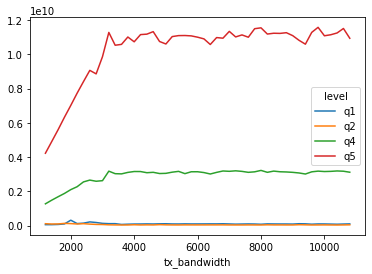

In [16]:
caption = '''
This graph shows the time taken executing packets on each level of packet processing for a given bandwith
'''

df2=spark.sql("select level, tx_bandwidth, sum(pkt_total) as time from LOGS group by level, tx_bandwidth order by tx_bandwidth")

df_2 = df2.toPandas()
df_2 = df_2.pivot(index='tx_bandwidth', columns='level', values='time')

df_2.plot()
print(caption)


This graph shows the amount of time spent handling context switches for each TX bandwidth



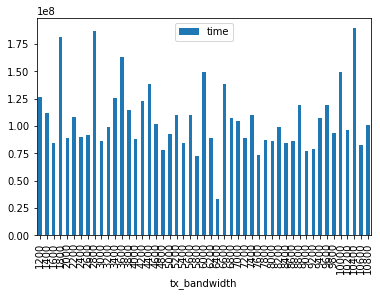

In [17]:
caption = '''
This graph shows the amount of time spent handling context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(cs_total) as time from LOGS group by tx_bandwidth order by tx_bandwidth")

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='time')
print(caption)

+------------+-------+
|tx_bandwidth|  count|
+------------+-------+
|        1200| 9139.0|
|        1400|10997.0|
|        1600|12538.0|
|        1800|14386.0|
|        2000|14090.0|
|        2200|16415.0|
|        2400|16586.0|
|        2600|17395.0|
|        2800|16188.0|
|        3000|16841.0|
|        3200|18871.0|
|        3400|18069.0|
|        3600|18522.0|
|        3800|21376.0|
|        4000|24026.0|
|        4200|23092.0|
|        4400|16488.0|
|        4600|23901.0|
|        4800|22067.0|
|        5000|22246.0|
|        5200|22551.0|
|        5400|21400.0|
|        5600|22343.0|
|        5800|21155.0|
|        6000|21680.0|
|        6200|19503.0|
|        6400|  629.0|
|        6600|24101.0|
|        6800|24684.0|
|        7000|21605.0|
|        7200|24606.0|
|        7400|23244.0|
|        7600|20728.0|
|        7800|23779.0|
|        8000|23628.0|
|        8200|21643.0|
|        8400|21831.0|
|        8600|22514.0|
|        8800|22295.0|
|        9000|23215.0|
|        92

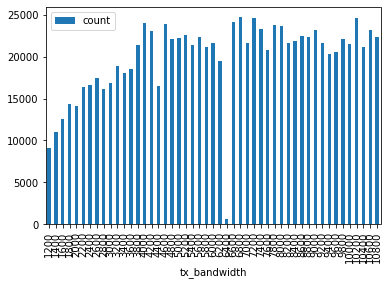

In [18]:
caption = '''
This graph shows the number of context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(cs_count) as count from LOGS group by tx_bandwidth order by tx_bandwidth")

df3.show(100)
df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='count')
print(caption)

+-----+------------+-----------------+
|level|tx_bandwidth|        rx_gbytes|
+-----+------------+-----------------+
|   q4|        1200|8.369999999999964|
|   q2|        1200|8.369999999999964|
|   q1|        1200|8.369999999999965|
|   q5|        1200|8.369999999999964|
|   q5|        1400|9.759999999999993|
|   q4|        1400|9.759999999999993|
|   q1|        1400|9.759999999999993|
|   q2|        1400|9.759999999999993|
|   q5|        1600|11.20000000000003|
|   q1|        1600|11.20000000000003|
|   q4|        1600|11.20000000000003|
|   q2|        1600|11.20000000000003|
|   q5|        1800|             12.5|
|   q1|        1800|             12.5|
|   q2|        1800|             12.5|
+-----+------------+-----------------+
only showing top 15 rows



<AxesSubplot:xlabel='tx_bandwidth'>

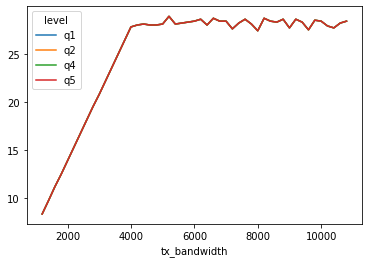

In [19]:
caption = '''
This graph shows the amount of giga bytes on each level of packet processing for a given bandwith
'''

results_df.createOrReplaceTempView("LOGS")
df2=spark.sql("select level, tx_bandwidth, avg(rx_gbytes) as rx_gbytes from LOGS group by level, tx_bandwidth order by tx_bandwidth ")
df2.show(15, truncate=True)

df_2 = df2.toPandas()
df_2 = df_2.pivot(index='tx_bandwidth', columns='level', values='rx_gbytes')

df_2.plot()

+------------+------------------+
|tx_bandwidth|         rx_gbytes|
+------------+------------------+
|        1200|  8.36999999999991|
|        1400| 9.760000000000138|
|        1600| 11.19999999999988|
|        1800|              12.5|
|        2000|13.899999999999814|
|        2200|15.299999999999919|
|        2400|16.700000000000134|
|        2600|18.100000000000232|
|        2800|              19.5|
|        3000|20.799999999999695|
|        3200|22.200000000000266|
|        3400| 23.60000000000025|
|        3600|              25.0|
|        3800|26.399999999999764|
|        4000|  27.7999999999997|
+------------+------------------+
only showing top 15 rows


This graph shows the number receive bytes for each TX bandwidth



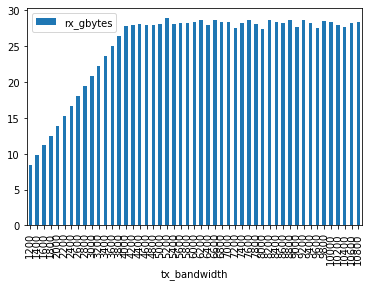

In [20]:
caption = '''
This graph shows the number receive bytes for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(rx_gbytes) rx_gbytes from LOGS group by tx_bandwidth order by tx_bandwidth")
df3.show(15, truncate=True)

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='rx_gbytes')
print(caption)

+------------+-------------------+
|tx_bandwidth|           pkt_loss|
+------------+-------------------+
|        1200|0.08500000000000074|
|        1400|0.15999999999999778|
|        1600|0.17000000000000143|
|        1800|0.18000000000000344|
|        2000| 0.1800000000000033|
|        2200|0.10999999999999951|
|        2400| 0.2000000000000007|
|        2600| 0.4100000000000017|
|        2800|  0.439999999999998|
|        3000|  0.579999999999996|
|        3200| 0.5699999999999943|
|        3400|  0.540000000000004|
|        3600|0.43000000000000504|
|        3800|0.47000000000000275|
|        4000|0.31999999999999557|
+------------+-------------------+
only showing top 15 rows


This graph shows the packet loss for each TX bandwidth



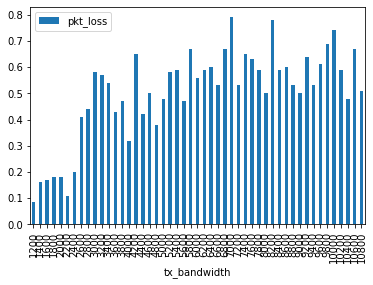

In [21]:
caption = '''
This graph shows the packet loss for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(pkt_loss) pkt_loss from LOGS group by tx_bandwidth order by tx_bandwidth")
df3.show(15, truncate=True)

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='pkt_loss')
print(caption)